# PART 2

In [24]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

In [25]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)


# QUESTION 19:
 In a brief paragraph discuss: If the VGG network is trained on a dataset with
perhaps totally different classes as targets, why would one expect the features derived from such a
network to have discriminative power for a custom dataset?
### A: We use the pre-trained model's architecture to create a new dataset from our input images in this approach. We'll import the Convolutional and Pooling layers but leave out the "top portion" of the model (the Fully-Connected layer).Recall that VGG16 has been trained on millions of images. Its convolutional layers and trained weights can detect generic features. In other words, we use the patterns that the NN found to be useful to classify images of a given problem to classify a completely different problem without retraining that part of the network.



# QUESTION 20: 
In a brief paragraph explain how the helper code base is performing feature
extraction.
### A:  The helper code uses a pretrained VGG16 modeled. Where VGG16 refers to a VGG model with 16 weight layers. It first resize the image into  224 x 224 for VGG16 to extract features. The steps of extracting features includes extract VGG-16 Feature Layers, extract VGG-16 Average Pooling Layer, converting the image into one-dimensional vector, then extract the first part of fully-connected layer from VGG16.

# QUESTION 21: 
How many pixels are there in the original images? How many features does
the VGG network extract per image; i.e what is the dimension of each feature vector for an image
sample?
### A: There pixels in the original images are not identical, however the images were resize into the same shape 224 x 224 . And there are 4096 features extracted per image with the VGG network.

In [3]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


# QUESTION 22: 
Are the extracted features dense or sparse? (Compare with sparse TF-IDF
features in text.)

### A: Comparing to the sparse TF-IDF features, the extracted feature is dense since there are no nonzero in the entities.

In [4]:
f_all.size - np.count_nonzero(f_all)

0

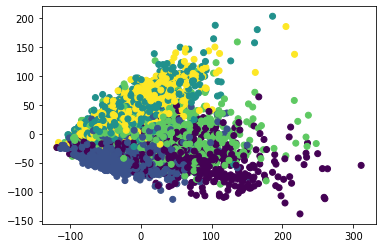

In [5]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

# QUESTION 23: 
In order to inspect the high-dimensional features, t-SNE is a popular off-the-shelf
choice for visualizing Vision features. Map the features you have extracted onto 2 dimensions with
t-SNE. Then plot the mapped feature vectors along x and y axes. Color-code the data points with
ground-truth labels. Describe your observation.

### A: According to the plot using t-SNE below, we can see that the digits are more clearly clustered in their own sub groups . If we used a clustering algorithm to pick out the separate clusters, we could probably quite accurately assign new points to a label. This is already a significant improvement over the PCA visualization we used earlier. 

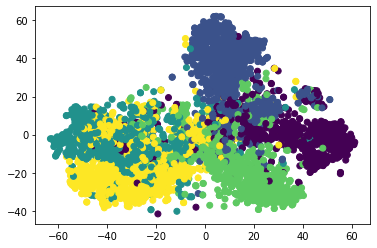

In [6]:
from sklearn.manifold import TSNE
f_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(f_all)
plt.scatter(*f_tsne.T, c=y_all)

# MLP Classifier


In [13]:

class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:

              optimizer.zero_grad()
              outputs = self(X_)

              loss = criterion(outputs, y_)
              loss.backward()
              optimizer.step()

        return self
    
    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################
        X = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y = torch.tensor(y_test, dtype=torch.int64, device='cuda')

        criterion = nn.NLLLoss()
        dataset = TensorDataset(X, y)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

        total = 0 
        corr = 0 

        with torch.no_grad():
          for (X,y) in dataloader : 
            output = self.model(X)
            _,pred = torch.max(output,1)
            total += y.size(0)
            corr  += (pred==y).sum().item()

        accuracy = (corr/total)*100 
      
        return accuracy

# Autoencoder

In [22]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [26]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.utils.extmath import randomized_svd
!pip install umap
!pip install umap-learn
import umap.umap_ as umap
!pip install hdbscan
import hdbscan
import pandas as pd


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#QUESTION 24:
Report the best result (in terms of rand score) within the table below.
For HDBSCAN, introduce a conservative parameter grid over min cluster size and min samples. 
### Here we set min_cluster_size and min_samples to 5 

### A: According to the results below we could find out that the top 3 best results are the followings
### 1.UMAP(metric='cosine', n_components=50), KMeans(max_iter=1000, n_clusters=5, n_init=30, random_state=0) 

### Adjusted Rand Score:  0.46505860677140987

### 2.UMAP(metric='cosine', n_components=50), AgglomerativeClustering(n_clusters=5)
### Adjusted Rand Score:  0.4484857156148361

### 3. Autoencoder(50)	AgglomerativeClustering(n_clusters=5)
### Adjusted Rand Score: 0.276835

In [12]:
df = pd.DataFrame(columns = ['Dimentionality Reduction','Clustering','Adjusted Rand score'])
reduce_dim = [TruncatedSVD(n_components=50, random_state=42), 
               umap.UMAP(n_components=50, metric='cosine'),
               Autoencoder(50)]

clustering = [KMeans( max_iter=1000, n_clusters=5, n_init=30, random_state=0),
                AgglomerativeClustering(n_clusters=5),
                hdbscan.HDBSCAN(min_cluster_size = 5,min_samples = 5)]  
for j in range(len(clustering)):
        cluster = clustering[j]
        result = cluster.fit_predict(f_all)
        rand = adjusted_rand_score(y_all, result)
        df.loc[len(df.index)] = ['None',str(clustering[j]), rand] 
        print("None, "+str(clustering[j]))
        print("Adjusted Rand Score: ", rand)
        
for i in range(3):
    for j in range(len(clustering)):
        
        reduce = reduce_dim[i]
        red_vec = reduce.fit_transform(f_all)
        cluster = clustering[j]
        result = cluster.fit_predict(red_vec)
        rand = adjusted_rand_score(y_all, result)
        df.loc[len(df.index)] = [ str(reduce_dim[i]) ,str(clustering[j]), rand] 
        print(str(reduce_dim[i])+", "+str(clustering[j]))
        print("Adjusted Rand Score: ", rand)

None, KMeans(max_iter=1000, n_clusters=5, n_init=30, random_state=0)
Adjusted Rand Score:  0.19468200056257093
None, AgglomerativeClustering(n_clusters=5)
Adjusted Rand Score:  0.18855278251971858
None, HDBSCAN(min_samples=5)
Adjusted Rand Score:  0.006705947729476718
TruncatedSVD(n_components=50, random_state=42), KMeans(max_iter=1000, n_clusters=5, n_init=30, random_state=0)
Adjusted Rand Score:  0.19124776241548638
TruncatedSVD(n_components=50, random_state=42), AgglomerativeClustering(n_clusters=5)
Adjusted Rand Score:  0.25287434471967624
TruncatedSVD(n_components=50, random_state=42), HDBSCAN(min_samples=5)
Adjusted Rand Score:  0.005231761020183455
UMAP(angular_rp_forest=True, metric='cosine', n_components=50, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}), KMeans(max_iter=1000, n_clusters=5, n_init=30, random_state=0)
Adjusted Rand Score:  0.46505860677140987
UMAP(angular_rp_forest=True

100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=120, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=120, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=1280, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1280, out_features=4096, bias=True)
  )
), KMeans(max_iter=1000, n_clusters=5, n_init=30, random_state=0)
Adjusted Rand Score:  0.21392776971951044


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=120, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=120, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=1280, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1280, out_features=4096, bias=True)
  )
), AgglomerativeClustering(n_clusters=5)
Adjusted Rand Score:  0.27683501986665715


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=120, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=120, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=1280, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1280, out_features=4096, bias=True)
  )
), HDBSCAN(min_samples=5)
Adjusted Rand Score:  0.023707912767962632


In [15]:
df.sort_values(by='Adjusted Rand score',ascending=False)

,Dimentionality Reduction,Clustering,Adjusted Rand score
6,"UMAP(angular_rp_forest=True, metric='cosine', ...","KMeans(max_iter=1000, n_clusters=5, n_init=30,...",0.465059
7,"UMAP(angular_rp_forest=True, metric='cosine', ...",AgglomerativeClustering(n_clusters=5),0.448486
10,Autoencoder(\n (encoder): Sequential(\n (0...,AgglomerativeClustering(n_clusters=5),0.276835
4,"TruncatedSVD(n_components=50, random_state=42)",AgglomerativeClustering(n_clusters=5),0.252874
9,Autoencoder(\n (encoder): Sequential(\n (0...,"KMeans(max_iter=1000, n_clusters=5, n_init=30,...",0.213928
0,None,"KMeans(max_iter=1000, n_clusters=5, n_init=30,...",0.194682
3,"TruncatedSVD(n_components=50, random_state=42)","KMeans(max_iter=1000, n_clusters=5, n_init=30,...",0.191248
1,None,AgglomerativeClustering(n_clusters=5),0.188553
8,"UMAP(angular_rp_forest=True, metric='cosine', ...",HDBSCAN(min_samples=5),0.094940
11,Autoencoder(\n (encoder): Sequential(\n (0...,HDBSCAN(min_samples=5),0.023708


In [19]:
f_all[1].shape

(4096,)

#QUESTION 25: 
Report the test accuracy of the MLP classifier on the original VGG features.
Report the same when using the reduced-dimension features (you have freedom in choosing the
dimensionality reduction algorithm and its parameters). Does the performance of the model suffer
with the reduced-dimension representations? Is it significant? Does the success in classification
make sense in the context of the clustering results obtained for the same features in Question 24.

### A: I test on the following three results, which is:
### 1.MLP on VGG without reduced-dimension, Accurracy: 90.46321525885558
### 2.MLP on VGG with UMAP (n_components = 50, metric = 'cosine') reduction, Accuracy : 84.87738419618529
### 3.MLP on VGG with Autoencoder(50) reduction, Accuracy : 87.60217983651226

### Base on the results, we can observe that the performance of the model suffer with the reduced-dimension representations. However, it is not very significant with about at most 5% of accuracy. Also, since MLP learns compless features and predicts the classes based on learning, and clustering models predict classes based on distance, it is likely that MLP is better on complex data.

In [27]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(f_all,y_all,test_size=0.2)
mlp = MLP(f_all.shape[1])
mlp.train(X_train,y_train)
mlp.eval(X_test,y_test)
     
score = mlp.eval(X_test,y_test)
print("MLP on VGG without reduced-dimension, Accurracy:", score)
#MLP on VGG with UMAP (n_components = 50, metric = 'cosine) reduction
umap = umap.UMAP(n_components=50, metric='cosine')
red_umap = umap.fit_transform(f_all)
X_train,X_test,y_train,y_test = train_test_split(red_umap,y_all,test_size=0.2)
mlp = MLP(red_umap.shape[1])
mlp.train(X_train,y_train)
mlp.eval(X_test,y_test)
score = mlp.eval(X_test,y_test)
print("MLP on VGG with UMAP (n_components = 50, metric = 'cosine) reduction, Accuracy :", score)
#MLP on VGG with Autoencoder(50)
red_auto = Autoencoder(50).fit_transform(f_all)
X_train,X_test,y_train,y_test = train_test_split(red_auto,y_all,test_size=0.2)
mlp = MLP(red_auto.shape[1])
mlp.train(X_train,y_train)
mlp.eval(X_test,y_test)
score = mlp.eval(X_test,y_test)
print("MLP on VGG with Autoencoder(50) reduction, Accuracy :", score)



100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


MLP on VGG without reduced-dimension, Accurracy: 90.46321525885558


100%|██████████| 100/100 [00:09<00:00, 10.64it/s]


MLP on VGG with UMAP (n_components = 50, metric = 'cosine) reduction, Accuracy : 84.87738419618529


100%|██████████| 100/100 [00:06<00:00, 15.83it/s]

MLP on VGG with Autoencoder(50) reduction, Accuracy : 87.60217983651226
